# 22_1 Regression - Tier

Focus on Tier trips only starting at stations

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import shapely
import hashlib
import holidays
from shapely import Point, wkt
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro, anderson, norm, expon, gamma
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


## Load and prepare data

In [2]:
data_month_double = '07'

In [3]:
# read final data
data = pd.read_csv("../../../20_Final_Data.csv")

/tmp/ipykernel_435207/974816303.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../../20_Final_Data_NEW_TEST.csv")


In [4]:
tier = pd.read_parquet("../Data/12_tier_part2.parquet")
next = pd.read_parquet("../Data/15_nextbike_part2.parquet")

In [5]:
tier['trip_duration_seconds'] = tier['trip_duration'].dt.total_seconds()
next['trip_duration_seconds'] = next['trip_duration'].dt.total_seconds()

In [6]:
# transform geometry
data['station_point'] = data['station_point'].apply(wkt.loads)

In [7]:
data['buffer_zone'] = shapely.wkt.loads(data['buffer_zone'])

In [8]:
data = gpd.GeoDataFrame(data, geometry='station_point')

In [9]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

In [10]:
#data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], inplace=True)

In [11]:
data['actual_arrival_time'] = pd.to_datetime(data['actual_arrival_time'])
data['actual_departure_time'] = pd.to_datetime(data['actual_departure_time'])
data['scheduled_arrival_time'] = pd.to_datetime(data['scheduled_arrival_time'])
data['scheduled_departure_time'] = pd.to_datetime(data['scheduled_departure_time'])

In [12]:
data = gpd.GeoDataFrame(data, geometry='buffer_zone')

In [13]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2564861 entries, 0 to 2564860
Data columns (total 56 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   route_id                             int64         
 1   agency_id                            int64         
 2   route_short_name                     object        
 3   route_type                           int64         
 4   route_type_name                      object        
 5   agency_name                          object        
 6   service_id                           int64         
 7   trip_id                              object        
 8   trip_headsign                        object        
 9   direction_id                         int64         
 10  shape_id                             int64         
 11  stop_id                              int64         
 12  actual_arrival_time                  datetime64[ns]
 13  actual_departure_ti

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data['arrival_delay'] = pd.to_timedelta(data['arrival_delay'])
data['departure_delay'] = pd.to_timedelta(data['departure_delay'])

In [16]:
#NEW FEATURES
data['delay_category'] = data['arrival_delay'].apply(lambda x: 1 if x > pd.Timedelta(0) else 0 if x == pd.Timedelta(0) else -1)
data['cancelled_trip'] = np.where((data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()), 1, 0)

In [17]:
data['arrival_delay_float'] = data['arrival_delay'].astype(str)
data['arrival_delay_float'] = data['arrival_delay_float'].str.split(' ', n=2).str[-1]
data['arrival_delay_float'] = data['arrival_delay_float'].astype(str)
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float'])
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float']).dt.total_seconds() / 60

In [18]:
data['departure_delay_float'] = data['departure_delay'].astype(str)
data['departure_delay_float'] = data['departure_delay_float'].str.split(' ', n=2).str[-1]
data['departure_delay_float'] = data['departure_delay_float'].astype(str)
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float'])
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float']).dt.total_seconds() / 60

In [19]:
data['delay'] = data['departure_delay'].apply(lambda x: 1 if x > pd.Timedelta(0) else 0)
data['no_delay'] = data['departure_delay'].apply(lambda x: 1 if x == pd.Timedelta(0) else 0)
data['nan_delay'] = data['departure_delay'].apply(lambda x: 1 if pd.isna(x) else 0)

In [20]:
data['delay_span_int'] = 0

for index in data.index:
    if data['delay_span'][index] == '0':
        data['delay_span_int'][index] = 0
    if data['delay_span'][index] == '0-5':
        data['delay_span_int'][index] = 1
    if data['delay_span'][index] == '5-10':
        data['delay_span_int'][index] = 2
    if data['delay_span'][index] == '10-15':
        data['delay_span_int'][index] = 3
    if data['delay_span'][index] == '15-20':
        data['delay_span_int'][index] = 4
    if data['delay_span'][index] == '20-30':
        data['delay_span_int'][index] = 5
    if data['delay_span'][index] == '30-45':
        data['delay_span_int'][index] = 6
    if data['delay_span'][index] == '45-60':
        data['delay_span_int'][index] = 7
 
    

/tmp/ipykernel_435207/1846020972.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['delay_span_int'][index] = 0
/tmp/ipykernel_435207/1846020972.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [21]:
# new colum that sets trips that not happend to -1
data['arrival_delay_new'] = data['arrival_delay'].fillna(-1)
data['arrival_delay_float_new'] = data['arrival_delay_float'].fillna(-1)
# new colum that sets trips that not happend to -1
data['departure_delay_new'] = data['departure_delay'].fillna(-1)
data['departure_delay_float_new'] = data['departure_delay_float'].fillna(-1)

In [22]:
data['current_precipitation_volume'].fillna(0, inplace=True)

/tmp/ipykernel_435207/969628070.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['current_precipitation_volume'].fillna(0, inplace=True)


In [23]:
delay = data[data['departure_delay'] > pd.Timedelta(0)]


In [24]:
no_delay = data[data['departure_delay'] == pd.Timedelta(0)]

In [25]:
nan_delay = data[data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()]
#nan_delay = data[data['arrival_delay'].isna()]
nan_delay

,route_id,agency_id,route_short_name,route_type,route_type_name,agency_name,service_id,trip_id,trip_headsign,direction_id,...,delay_category,cancelled_trip,delay,no_delay,nan_delay,delay_span_int,arrival_delay_new,arrival_delay_float_new,departure_delay_new,departure_delay_float_new
41,551,8,551,3,Bus,RSVG Rhein-Sieg-Verkehrsgesellschaft mbH,125,255-551-008-2071.2.22:033200-34-157_C0741D60-B...,Bonn Hbf,1,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
42,551,8,551,3,Bus,RSVG Rhein-Sieg-Verkehrsgesellschaft mbH,125,159-551-008-687.2.36:044000-33-157_FAA787CB-18...,Troisdorf Bf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
43,551,8,551,3,Bus,RSVG Rhein-Sieg-Verkehrsgesellschaft mbH,125,159-551-008-687.2.36:044000-33-157_FAA787CB-18...,Troisdorf Bf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
44,551,8,551,3,Bus,RSVG Rhein-Sieg-Verkehrsgesellschaft mbH,125,159-551-008-687.2.36:044000-33-157_FAA787CB-18...,Troisdorf Bf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
45,551,8,551,3,Bus,RSVG Rhein-Sieg-Verkehrsgesellschaft mbH,125,159-551-008-687.2.36:044000-33-157_FAA787CB-18...,Troisdorf Bf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564854,689,6,N9,3,Bus,SWB Stadtwerke Bonn Verkehrs GmbH,43,6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...,Bonn Hbf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
2564856,689,6,N9,3,Bus,SWB Stadtwerke Bonn Verkehrs GmbH,43,6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...,Bonn Hbf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
2564857,689,6,N9,3,Bus,SWB Stadtwerke Bonn Verkehrs GmbH,43,6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...,Bonn Hbf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0
2564858,689,6,N9,3,Bus,SWB Stadtwerke Bonn Verkehrs GmbH,43,6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...,Bonn Hbf,0,...,-1,1,0,0,1,0,-1,-1.0,-1,-1.0


### Definition of functions

In [26]:
def calc_stats(data, column_name):

    #generated by Copilot

    sum = data[column_name].sum()

#Central Tendency

    rows = len(data.index)
    # Calculate mean (average)
    mean = data[column_name].mean()
    # Calculate median (middle value)
    median = data[column_name].median()
    # Calculate mode (most frequent value)
    mode = data[column_name].mode()
    #calc maximum
    max = data[column_name].max()
    #calc minimum
    min = data[column_name].min()

    # Calculate range
    data_range = data[column_name].max() - data[column_name].min()
    # Calculate coefficient of variation of range
    cvr = data_range / mean
    # Calculate coefficient of variation of mean
    cvm = mean / mean
    # Calculate coefficient of variation of median
    cvmed = median / mean
    # Calculate coefficient of variation of mode
    cvmode = mode / mean
    # Calculate coefficient of variation of standard deviation
   

# Variability
# Measure of how spread out the values in a data set are
    
    # Calculate standard deviation (average amount of variability in a dataset; tells how far each score lies from the mean; the larger the standard deviation, the more variable the data)
    std_dev = data[column_name].std()
    # Calculate variance (average squared deviation from the mean; square of standard deviation; units of varriance are much larger than those of a typical value in the dataset)
    variance = data[column_name].var()
    # Calculate coefficient of variation
    cv = std_dev / mean # standard deviation divided by the mean; measures the relative variability of a dataset; allows comparison of variability of datasets with different units of measurement
    # Calculate 25th percentile
    percentile_25 = data[column_name].quantile(0.25)
    # Calculate 75th percentile
    percentile_75 = data[column_name].quantile(0.75)
    # Calculate interquartile range
    iqr = percentile_75 - percentile_25 # difference between the 75th and 25th percentiles; measures the spread of the middle 50% of values in a dataset
    # Calculate coefficient of quartile deviation
    qd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of coefficient of variation
    cvcv = std_dev / mean
    # Calculate coefficient of variation of coefficient of quartile deviation
    cvqd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of range

#Measure of Shape

    # Calculate skewness - measure of how much the probability distribution of a random variable deviates from the normal distribution
    skewness = data[column_name].skew()
    
    # Calculate kurtosis
    kurtosis = data[column_name].kurtosis()

    # Calculate coefficient of skewness
    cs = skewness / std_dev
    # Calculate coefficient of kurtosis
    ck = kurtosis / std_dev
    # Calculate coefficient of variation of skewness
    cvs = skewness / std_dev
    # Calculate coefficient of variation of kurtosis
    cvk = kurtosis / std_dev
    # Calculate coefficient of variation of coefficient of skewness
    cvcs = skewness / std_dev
    # Calculate coefficient of variation of coefficient of kurtosis
    cvck = kurtosis / std_dev
    
    
    
    #return "column: " + str(column_name), "mean: " + str(mean), "median: " + str(median), "mode: " + str(mode), "std_dev: " + str(std_dev), "variance: " + str(variance), "skewness: "+ str(skewness), "kurtosis: " + str(kurtosis), "percentile_25: "+ str(percentile_25), "percentile_75: "+ str(percentile_75), "iqr: " + str(iqr), "range: "+ str(data_range), "cv"+ str(cv), "qd: "+str(qd), "cs: "+ str(cs), "ck: " + str(ck), "csv: "+ str(cvs), "cvk: "+ str(cvk), "cvcs: "+ str(cvcs), "cvck: " +str(cvck), "cvcv: "+ str(cvcv), "cvqd: "+ str (cvqd), "cvr: "+ str(cvr), "cvm: " + str(cvm), "cvmed: " + str(cvmed), "cvmode: "+ str(cvmode)

    return pd.DataFrame({'column': [column_name],
                         'number of rows': [rows],                       
                         'sum': [sum],
                         'mean': [mean],
                         'median': [median],
                         'mode': [mode],
                         'max': [max],
                         'min': [min],
                         'std_dev': [std_dev],
                         'variance': [variance],
                         'skewness': [skewness],
                         'kurtosis': [kurtosis],
                         'percentile_25': [percentile_25],
                         'percentile_75': [percentile_75],
                         'iqr': [iqr],
                         'range': [data_range],
                         'cv': [cv],
                         'qd': [qd],
                         'cs': [cs],
                         'ck': [ck],
                         'cvs': [cvs],
                         'cvk': [cvk],
                         'cvcs': [cvcs],
                         'cvck': [cvck],
                         'cvcv': [cvcv],
                         'cvqd': [cvqd],
                         'cvr': [cvr],
                         'cvm': [cvm],
                         'cvmed': [cvmed],
                         'cvmode': [cvmode]}).T

In [27]:
# create a shorter dataframe with most interesting columns - for better overview
def show_short_df(dataframe):
    delay_short = dataframe[['route_id', 'trip_id', 'stop_id', 'stop_name', 'scheduled_arrival_time', 'actual_arrival_time', 'scheduled_departure_time', 'actual_departure_time', 'arrival_delay', 'departure_delay', 'tier_trips_count', 'tier_trips_end_at_station_count', 'nextbike_trips_count', 'nextbike_trips_end_at_station_count', 'buffer_zone', 'arrival_delay_float', 'departure_delay_float']]
    return delay_short

In [28]:
# transform geometry
point_start = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["start_location"], crs=4326))
point_end = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["end_location"], crs=4326))
# drop geometry columns in wrong format
tier = tier.drop(columns=["start_location", "end_location"])
# replace geometry columns with correct format
tier['start_location'] = point_start
tier['end_location'] = point_end

In [29]:
# get the data from the tier / nextbike dataset
def check_micromobility_datasets(type, data):
    
    if type == 'tier':

        return_data = tier.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['tier_trips_id'].str.split(' ').explode().dropna():   # iterate over all tier ids in the dataframe
            
            id = tier[tier['tier_trips_id'] == int(float(item))]   # get the rows with the specific id
            return_data = pd.concat([return_data, id])  # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)
            
    if type == 'next':

        return_data = next.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['nextbike_trips_id'].str.split(' ').explode().dropna():   # iterate over all nextbike ids in the dataframe
            
            id = next[next['nextbike_trips_id'] == int(float(item))]  # get the rows with the specific id
            return_data = pd.concat([return_data, id]) # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)

    return return_data

In [30]:
def get_station_to_station(data, mode):
    
    if mode == 'tier':

        data = data[data['tier_trips_start_at_station_id'].notna() & data['tier_trips_end_at_station_id'].notna()]
        data = data[data['tier_trips_start_at_station_id'] != data['tier_trips_end_at_station_id']]
        data = data[data['tier_trips_start_at_station_id'] != 0]
        data = data[data['tier_trips_end_at_station_id'] != 0]
    t = check_micromobility_datasets('tier', data)
    n = check_micromobility_datasets('next', data)

    t = t[t['end_stop_id'].notna() & t['start_stop_id'].notna()]
    n = n[n['end_stop_id'].notna() & n['start_stop_id'].notna()]
    
    return t, n

In [31]:
# map the start and end locations of the trips on a map and connect them with a line

def map_buffer_zones(dataset):
    
    micromobility_data = check_micromobility_datasets('tier', dataset)
    
    # Create a folium map object
    m = folium.Map(location=[50.73743, 7.09821], zoom_start=12)

    # Iterate over each row in the micromobility data
    for index, row in micromobility_data.iterrows():
        # Get the start and end locations
        start_location = row['start_location']
        end_location = row['end_location']
        
        # Get the start and end stop names
        start_stop_name = row['start_stop_name']
        end_stop_name = row['end_stop_name']
        # Add markers for the start and end locations
        folium.Marker(location=[start_location.y, start_location.x], popup=start_stop_name).add_to(m)
        folium.Marker(location=[end_location.y, end_location.x], popup=end_stop_name).add_to(m)
        # Create a line connecting the start and end locations
        folium.PolyLine(locations=[[start_location.y, start_location.x], [end_location.y, end_location.x]], color='blue').add_to(m)
        
    # Display the map
    return m

In [32]:
def get_stats(data, var):

    if var == 'all':
        var = data.columns

    df = pd.DataFrame()

    for i in var:
        df = pd.concat([df, calc_stats(data, i)], axis=1)

    df.columns = df.iloc[0]
    df = df[1:]
    
    return df

In [33]:
def get_micro_stats(data, operator):
    
    if operator == 'tier':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    elif operator == 'next':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    
    return dataframe

In [34]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
                 #Bbox = dict(facecolor = 'red', alpha =.8))

route_id', 'agency_id',
       'route_short_name', 'route_type', 'route_type_name', 'agency_name',
       'service_id', 'trip_id', 'trip_headsign', 'direction_id', 'shape_id',
       'stop_id', 'actual_arrival_time', 'actual_departure_time',
       'vrs_timestamp', 'stop_sequence', 'stop_headsign', 'stop_name',
       'station_point', 'buffer_zone', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'departure_delay',
       'service', 'date', 'weekday', 'transfer_stop', 'tier_trips_count',
       'tier_trips_id', 'nextbike_trips_count', 'nextbike_trips_id',
       'current_time', 'current_temp', 'current_feels_like',
       'current_cloudiness', 'current_visibility', 'current_wind_speed',
       'current_description', 'current_precipitation_volume', 'holiday',
       'holiday_NRW', 'holiday_name', 'holiday_name_NRW'

In [35]:
data.columns

Index(['route_id', 'agency_id', 'route_short_name', 'route_type',
       'route_type_name', 'agency_name', 'service_id', 'trip_id',
       'trip_headsign', 'direction_id', 'shape_id', 'stop_id',
       'actual_arrival_time', 'actual_departure_time', 'vrs_timestamp',
       'stop_sequence', 'stop_headsign', 'stop_name', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'departure_delay',
       'service', 'date', 'weekday', 'transfer_stop', 'tier_trips_count',
       'tier_trips_id', 'tier_trips_end_at_station_count',
       'tier_trips_end_at_station_id', 'station_point', 'buffer_zone',
       'nextbike_trips_count', 'nextbike_trips_id',
       'nextbike_trips_end_at_station_count',
       'nextbike_trips_end_at_station_id', 'current_time', 'current_temp',
       'current_feels_like', 'current_cloudiness', 'current_visibility',
       'current_wind_speed', 'current_description',
       'current_precipitation_volume', 'arrival_delay_float',
       'departure_

## Def Features

In [36]:
# create dummy variables for categories
delay_span_dummy = data[['delay_span']]
delay_span_dummy = pd.get_dummies(delay_span_dummy, columns=['delay_span'], drop_first=True)


weekday_dummy = data[['weekday']]
weekday_dummy = pd.get_dummies(weekday_dummy, columns=['weekday'], drop_first=True)


time_span_dummy = data[['time_span']]
time_span_dummy = pd.get_dummies(time_span_dummy, columns=['time_span'], drop_first=True)

data_slim = data.drop(columns=['route_id', 'agency_id', 'route_short_name',
       'route_type_name', 'agency_name', 'service_id', 'trip_id',
       'trip_headsign', 'direction_id', 'shape_id',
       'actual_arrival_time', 'actual_departure_time', 'vrs_timestamp',
       'stop_sequence', 'stop_headsign', 'stop_name', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'date', 'tier_trips_id', 'tier_trips_end_at_station_count',
       'tier_trips_end_at_station_id', 'station_point', 'buffer_zone',
       'nextbike_trips_count', 'nextbike_trips_id',
       'nextbike_trips_end_at_station_count', 'departure_delay', 'actual_arrival_time_float', 'time_span_int', 'delay_category', 'departure_delay_new',
       'nextbike_trips_end_at_station_id', 'current_time', 'current_feels_like', 'current_cloudiness', 'current_visibility',
       'current_wind_speed', 'current_description', 'arrival_delay_float',  'actual_departure_time_float',  'time_span_arrival', 'time_span_int_arrival', 'delay_span_int', 'arrival_delay_new', 'arrival_delay_float_new', 'arrival_delay_span'])

data_dummy = pd.get_dummies(data_slim, columns=['time_span', 'weekday', 'delay_span'], drop_first=True)

In [37]:
data_slim.columns

Index(['route_type', 'stop_id', 'service', 'weekday', 'transfer_stop',
       'tier_trips_count', 'current_temp', 'current_precipitation_volume',
       'departure_delay_float', 'delay_span', 'weather_int', 'weekend',
       'time_span', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay',
       'departure_delay_float_new'],
      dtype='object')

In [38]:
data_dummy.columns

Index(['route_type', 'stop_id', 'service', 'transfer_stop', 'tier_trips_count',
       'current_temp', 'current_precipitation_volume', 'departure_delay_float',
       'weather_int', 'weekend', 'cancelled_trip', 'delay', 'no_delay',
       'nan_delay', 'departure_delay_float_new', 'time_span_afternoon',
       'time_span_early morning', 'time_span_evening',
       'time_span_evening rush', 'time_span_lunch', 'time_span_morning rush',
       'time_span_until midday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'delay_span_0-5', 'delay_span_10-15',
       'delay_span_15-20', 'delay_span_20-30', 'delay_span_30-45',
       'delay_span_45-60', 'delay_span_5-10'],
      dtype='object')

# Test for Model

## Test

In [50]:
# Varianz und Mittelwert der abhängigen Variable
# Var > Mean -> Poisson nicht gut (bei großer Abweichung)
mean = data['tier_trips_count'].mean()
print(mean)
variance = data['tier_trips_count'].var()
print(variance)
dispersion_ratio = variance / mean
print(dispersion_ratio)

0.01972543541345905
0.024520258825239075
1.2430782039167776


In [55]:
corr_matrix = data_dummy.corr()
corr_matrix

,route_type,stop_id,service,transfer_stop,tier_trips_count,current_temp,current_precipitation_volume,departure_delay_float,weather_int,weekend,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,delay_span_0-5,delay_span_10-15,delay_span_15-20,delay_span_20-30,delay_span_30-45,delay_span_45-60,delay_span_5-10
route_type,1.000000,0.060355,0.016856,-0.065857,-0.014146,0.027113,-0.001331,0.026825,-0.003618,-0.008933,...,0.004911,0.002984,0.004350,0.059182,0.005625,0.008414,0.008273,0.007988,0.005451,0.008172
stop_id,0.060355,1.000000,-0.001685,-0.015772,-0.038461,0.006173,-0.000459,-0.000539,-0.001419,-0.001467,...,0.001104,0.000740,0.001130,0.019224,0.030173,-0.004215,0.014147,-0.006972,-0.009670,-0.006247
service,0.016856,-0.001685,1.000000,-0.007632,-0.000056,0.050747,0.001262,-0.020214,-0.000763,-0.095210,...,0.027363,0.027405,0.027388,0.012627,-0.001942,-0.002099,-0.007796,-0.034543,-0.026784,-0.000539
transfer_stop,-0.065857,-0.015772,-0.007632,1.000000,0.032019,-0.005364,-0.000140,-0.001756,0.000614,0.006757,...,-0.001854,-0.001280,-0.001870,-0.043125,-0.005749,0.002988,0.011454,0.014965,-0.004798,-0.002561
tier_trips_count,-0.014146,-0.038461,-0.000056,0.032019,1.000000,0.030810,-0.005728,-0.005052,-0.008855,0.003309,...,-0.001564,0.001559,-0.002265,-0.025788,-0.001731,-0.000431,-0.001009,0.000492,0.015995,-0.001762
current_temp,0.027113,0.006173,0.050747,-0.005364,0.030810,1.000000,-0.049263,-0.016466,-0.142011,0.135245,...,-0.126978,0.078613,-0.106187,0.025606,-0.002046,0.000572,-0.001695,-0.021065,-0.014491,0.008926
current_precipitation_volume,-0.001331,-0.000459,0.001262,-0.000140,-0.005728,-0.049263,1.000000,-0.003632,0.685637,0.087984,...,0.027576,-0.066925,-0.042474,-0.006357,-0.000857,-0.000513,-0.000959,-0.002646,-0.002144,-0.000870
departure_delay_float,0.026825,-0.000539,-0.020214,-0.001756,-0.005052,-0.016466,-0.003632,1.000000,-0.005550,0.006572,...,-0.002835,-0.001682,-0.002564,0.044318,0.091897,0.200583,0.245863,0.384454,0.191557,0.058298
weather_int,-0.003618,-0.001419,-0.000763,0.000614,-0.008855,-0.142011,0.685637,-0.005550,1.000000,0.067783,...,0.068347,-0.056565,-0.062573,-0.007977,-0.000623,-0.000165,-0.001100,-0.004030,-0.002951,-0.002118
weekend,-0.008933,-0.001467,-0.095210,0.006757,0.003309,0.135245,0.087984,0.006572,0.067783,1.000000,...,-0.288432,-0.288875,-0.288693,0.011333,0.006153,0.003714,-0.000079,0.011069,0.006178,-0.007732


In [56]:
# Calculate the correlation matrix
corr_matrix = data_dummy.corr()

# Select the target variable (dependent variable)
target_variable = 'tier_trips_count'

# Sort the correlation matrix by the absolute values of the correlation with the target variable
sorted_corr = corr_matrix[target_variable].abs().sort_values(ascending=False)

# Select the top k features with the highest correlation with the target variable
k = 10
selected_features = sorted_corr[1:k+1].index.tolist()

# Print the selected features
print("Selected features:")
print(selected_features)

Selected features:
['stop_id', 'no_delay', 'delay', 'transfer_stop', 'current_temp', 'delay_span_0-5', 'time_span_afternoon', 'delay_span_45-60', 'time_span_morning rush', 'route_type']


In [57]:
selected_features = data_dummy[['stop_id', 'no_delay', 'delay', 'transfer_stop', 'current_temp', 'delay_span_0-5', 'time_span_afternoon', 'delay_span_45-60', 'time_span_morning rush', 'route_type']]

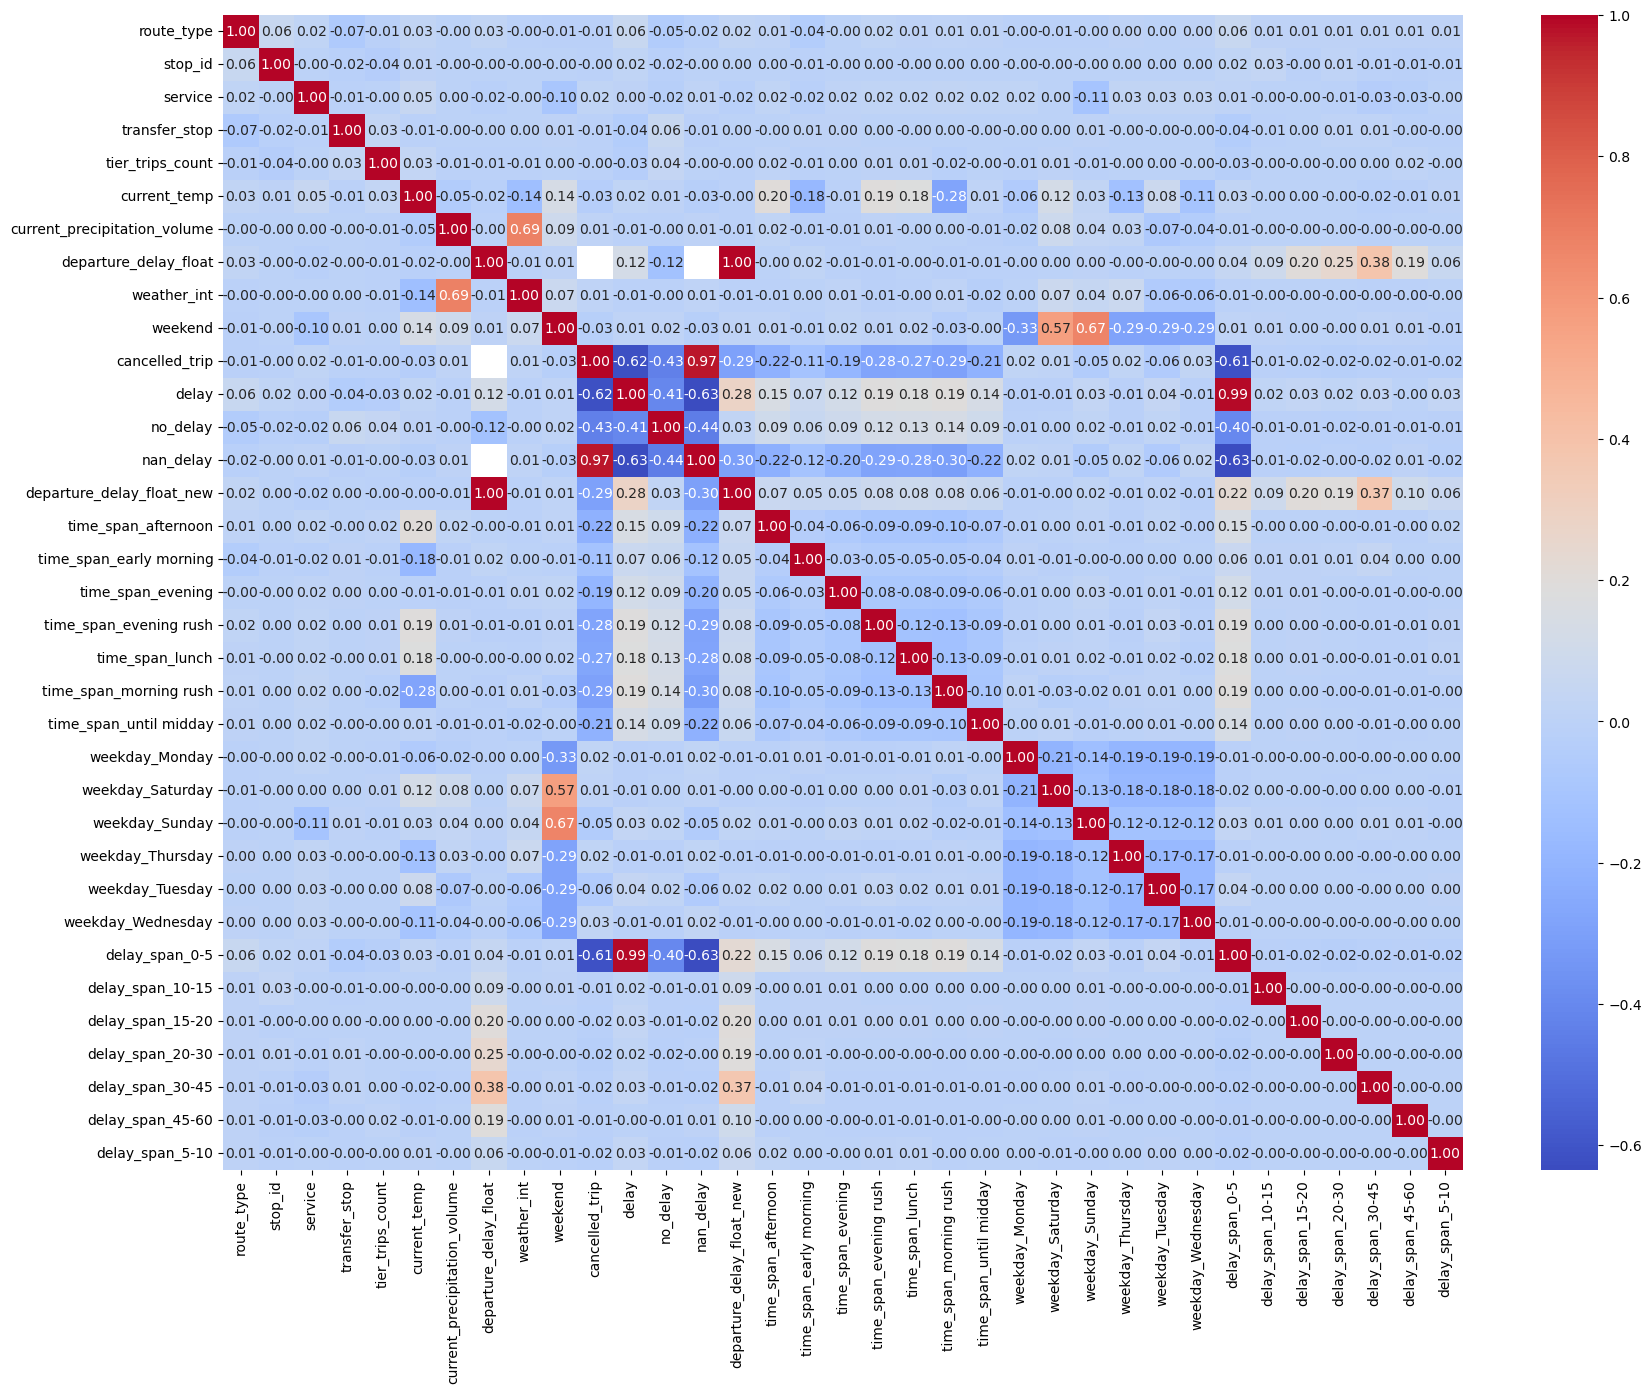

In [171]:
plt.figure(figsize=(20, 15))  # You can adjust the figure size as needed

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Save the heatmap in high resolution (300 DPI)
plt.savefig('high_res_heatmap.png', dpi=300, bbox_inches='tight')

# Show the heatmap
plt.show()

# Linear Regression

## Best Models

In [ ]:
X = data_dummy.drop(columns=["tier_trips_count", "departure_delay_float"])
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog)
result = poission_model.fit()
print(result.summary())

# bad model

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564829
Model Family:                Gaussian   Df Model:                           31
Link Function:               Identity   Scale:                        0.024287
Method:                          IRLS   Log-Likelihood:             1.1285e+06
Date:                Wed, 18 Sep 2024   Deviance:                       62292.
Time:                        23:51:01   Pearson chi2:                 6.23e+04
No. Iterations:                   100   Pseudo R-squ. (CS):           0.009567
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.000    141.073      0.0

In [ ]:
X = selected_features
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog)
result = poission_model.fit()
print(result.summary())

# no good fit

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564850
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                        0.024341
Method:                          IRLS   Log-Likelihood:             1.1256e+06
Date:                Wed, 18 Sep 2024   Deviance:                       62430.
Time:                        23:51:05   Pearson chi2:                 6.24e+04
No. Iterations:                     3   Pseudo R-squ. (CS):           0.007359
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0197   9.74e-05    202.485      0.0

### Other

In [58]:
short_data = data[['departure_delay', 'tier_trips_count']].copy()
short_data['departure_delay'] = pd.to_numeric(short_data['departure_delay'])

In [59]:
model = smf.ols(formula='tier_trips_count ~ departure_delay', data=short_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                      -0.009
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 18 Sep 2024   Prob (F-statistic):                nan
Time:                        23:46:43   Log-Likelihood:             1.1041e+06
No. Observations:             2564861   AIC:                        -2.208e+06
Df Residuals:                 2564860   BIC:                        -2.208e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.308e-40   1.81e-42    1

In [60]:
model = smf.ols(formula='tier_trips_count ~ departure_delay_float', data=data).fit()
print(model.summary())

# Bad model

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     38.87
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           4.54e-10
Time:                        23:46:44   Log-Likelihood:             6.4938e+05
No. Observations:             1522668   AIC:                        -1.299e+06
Df Residuals:                 1522666   BIC:                        -1.299e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.01

In [61]:
model = smf.ols(formula='tier_trips_count ~ departure_delay_new', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     30.83
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:47:27   Log-Likelihood:             1.1190e+06
No. Observations:             2564861   AIC:                        -2.238e+06
Df Residuals:                 2564681   BIC:                        -2.235e+06
Df Model:                         179                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [62]:
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new', data=data).fit()
print(model.summary())

## small decrease
# r 0 -> no capture -> bad

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     33.23
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           8.21e-09
Time:                        23:47:27   Log-Likelihood:             1.1162e+06
No. Observations:             2564861   AIC:                        -2.232e+06
Df Residuals:                 2564859   BIC:                        -2.232e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [63]:
model = smf.ols(formula='tier_trips_count ~ delay_span', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     338.6
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:47:33   Log-Likelihood:             1.1174e+06
No. Observations:             2564861   AIC:                        -2.235e+06
Df Residuals:                 2564853   BIC:                        -2.235e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0228    

	1.	Intercept (0.0228):
	•	The intercept is very small but statistically significant. This is the baseline value of tier_trips_count when all the predictor variables are zero.
	2.	delay_span[T.0–5] (-0.0083):
	•	This is a highly significant predictor (p-value = 0.000). A time span of 0 to 5 minutes in delay is associated with a decrease in the tier_trips_count by 0.0083 units. The confidence interval is tight, suggesting precision in the estimate.
	3.	delay_span[T.10–15] (-0.0188):
	•	This variable also has a significant negative coefficient, meaning that a delay of 10 to 15 minutes leads to a reduction in tier_trips_count by 0.0188 units.
	4.	delay_span[T.15–20] (-0.0056):
	•	This coefficient is not statistically significant (p = 0.131), meaning that delays in this range do not have a strong effect on the number of trips.
	5.	delay_span[T.20–30] (-0.0085):
	•	Another significant negative coefficient, showing a slight decrease in trips when delays are in this range.
	6.	delay_span[T.30–45] (0.0002):
	•	This variable has no significant effect on tier_trips_count (p-value = 0.964), implying that delays in the range of 30 to 45 minutes have a negligible impact on the number of trips.
	7.	delay_span[T.45–60] (0.1507):
	•	This is an interesting finding, as it shows a strong positive effect. A delay in the range of 45 to 60 minutes is associated with a substantial increase in tier_trips_count by 0.1507 units, and the effect is highly statistically significant.
	8.	delay_span[T.5–10] (-0.0143):
	•	Similar to the other smaller delays, this time range has a statistically significant negative effect on the number of trips, though the size of the effect is relatively small.

In [64]:
model = smf.ols(formula='tier_trips_count ~ cancelled_trip', data=data).fit()
print(model.summary())

# descrease
# significant but no erklärung

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     39.47
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           3.34e-10
Time:                        23:47:33   Log-Likelihood:             1.1162e+06
No. Observations:             2564861   AIC:                        -2.232e+06
Df Residuals:                 2564859   BIC:                        -2.232e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0202      0.000    161.

In [65]:
model = smf.ols(formula='tier_trips_count ~ delay', data=data).fit()
print(model.summary())

# negative, significant, poor

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2685.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:47:34   Log-Likelihood:             1.1175e+06
No. Observations:             2564861   AIC:                        -2.235e+06
Df Residuals:                 2564859   BIC:                        -2.235e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0236      0.000    191.689      0.0

In [66]:
model = smf.ols(formula='tier_trips_count ~ no_delay', data=data).fit()
print(model.summary())
# positive small no erklärung?

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3726.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:47:34   Log-Likelihood:             1.1181e+06
No. Observations:             2564861   AIC:                        -2.236e+06
Df Residuals:                 2564859   BIC:                        -2.236e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0165      0.000    149.104      0.0

In [67]:
model = smf.ols(formula='tier_trips_count ~ nan_delay', data=data).fit()
print(model.summary())
# ppor negative insignificant

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6165
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.432
Time:                        23:47:35   Log-Likelihood:             1.1162e+06
No. Observations:             2564861   AIC:                        -2.232e+06
Df Residuals:                 2564859   BIC:                        -2.232e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0198      0.000    155.942      0.0

In [68]:
X = data[['departure_delay_float_new', 'current_temp', 'current_precipitation_volume', 'service', 'delay_span_int', 'time_span_int', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.OLS(y, exog)
result = poission_model.fit()
print(result.summary())

# No Good Fit but significant factors - most influential so far

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     819.4
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:47:37   Log-Likelihood:             1.1207e+06
No. Observations:             2564861   AIC:                        -2.241e+06
Df Residuals:                 2564849   BIC:                        -2.241e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0197   9.76e-05    202.096      0.0

# Poisson Regression

## Best Models

In [ ]:
agg_station_date_10min = data.groupby(['stop_id', 'stop_name', pd.Grouper(key='scheduled_arrival_time', freq='10Min')]).sum(numeric_only=True)

In [ ]:
agg_station_date_10min.isna().any()

route_id                               False
agency_id                              False
route_type                             False
service_id                             False
direction_id                           False
shape_id                               False
vrs_timestamp                          False
stop_sequence                          False
service                                False
transfer_stop                          False
tier_trips_count                       False
tier_trips_end_at_station_count        False
nextbike_trips_count                   False
nextbike_trips_end_at_station_count    False
current_temp                           False
current_feels_like                     False
current_cloudiness                     False
current_visibility                     False
current_wind_speed                     False
current_precipitation_volume           False
arrival_delay_float                    False
departure_delay_float                  False
actual_arr

In [ ]:
agg_station_date_10min

route_id  agency_id  \
stop_id stop_name            scheduled_arrival_time                        
43      Bonn Propsthof Nord  2023-07-01 00:50:00           16          1   
                             2023-07-01 01:20:00           16          1   
                             2023-07-01 01:50:00           32          2   
                             2023-07-01 02:00:00           16          1   
                             2023-07-01 02:50:00           16          1   
...                                                       ...        ...   
9780    Bonn Georg-Elser-Weg 2023-07-31 22:50:00          604          6   
                             2023-07-31 23:10:00          604          6   
                             2023-07-31 23:20:00          604          6   
                             2023-07-31 23:40:00          604          6   
                             2023-08-01 00:10:00          604          6   

                                                     route_type  service_id  \
stop_id stop_name            scheduled_arrival_time                           
43      Bonn Propsthof Nord  2023-07-01 00:50:00              0       11525   
                             2023-07-01 01:20:00              0       11525   
                             2023-07-01 01:50:00              0       23061   
                             2023-07-01 02:00:00              0       11525   
                             2023-07-01 02:50:00              0       11525   
...                                                         ...         ...   
9780    Bonn Georg-Elser-Weg 2023-07-31 22:50:00              3          43   
                             2023-07-31 23:10:00              3          43   
                             2023-07-31 23:20:00              3          43   
                             2023-07-31 23:40:00              3          43   
                             2023-08-01 00:10:00              3          43   

                                                     direction_id  shape_id  \
stop_id stop_name            scheduled_arrival_time                           
43      Bonn Propsthof Nord  2023-07-01 00:50:00                0      3176   
                             2023-07-01 01:20:00                0      3203   
                             2023-07-01 01:50:00                0      6329   
                             2023-07-01 02:00:00                1      3230   
                             2023-07-01 02:50:00                0      3021   
...                                                           ...       ...   
9780    Bonn Georg-Elser-Weg 2023-07-31 22:50:00                1      5633   
                             2023-07-31 23:10:00                0      5377   
                             2023-07-31 23:20:00                1      5633   
                             2023-07-31 23:40:00                0      5377   
                             2023-08-01 00:10:00                0      5377   

                                                     vrs_timestamp  \
stop_id stop_name            scheduled_arrival_time                  
43      Bonn Propsthof Nord  2023-07-01 00:50:00               308   
                             2023-07-01 01:20:00              1304   
                             2023-07-01 01:50:00              7108   
                             2023-07-01 02:00:00              1304   
                             2023-07-01 02:50:00             14304   
...                                                            ...   
9780    Bonn Georg-Elser-Weg 2023-07-31 22:50:00            220312   
                             2023-07-31 23:10:00            213806   
                             2023-07-31 23:20:00            223304   
                             2023-07-31 23:40:00            214807   
                             2023-08-01 00:10:00            221806   

                                                     stop_sequence  service  \
stop_id stop_name 

In [42]:
poisson_model = smf.poisson('tier_trips_count ~ departure_delay_float_new', data=agg_station_date_10min).fit()
print(poisson_model.summary())

Optimization terminated successfully.
         Current function value: 0.170072
         Iterations 18
                          Poisson Regression Results                          
Dep. Variable:       tier_trips_count   No. Observations:              1290080
Model:                        Poisson   Df Residuals:                  1290078
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.1717
Time:                        23:46:30   Log-Likelihood:            -2.1941e+05
converged:                       True   LL-Null:                   -2.6489e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.7549      0.005   -706.335      0.000      -3

#######

In [ ]:
X = selected_features
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit(method="lbfgs")
print(result.summary())

# significt impact, low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564850
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -2.4268e+05
Date:                Wed, 18 Sep 2024   Deviance:                   3.9183e+05
Time:                        23:52:16   Pearson chi2:                 3.34e+06
No. Iterations:                    15   Pseudo R-squ. (CS):           0.008328
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1469      0.006   -747.400      0.0

In [ ]:
X = data_dummy.drop(columns=['tier_trips_count', 'departure_delay_float'])
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit(method="lbfgs")
print(result.summary())

# strong impact but low variance erklärung

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564829
Model Family:                 Poisson   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -2.4196e+05
Date:                Wed, 18 Sep 2024   Deviance:                   3.9041e+05
Time:                        23:51:53   Pearson chi2:                 3.29e+06
No. Iterations:                    16   Pseudo R-squ. (CS):           0.008880
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1584      0.006   -742.781      0.0

### Other

In [72]:
X = data[['departure_delay']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# not significant decrease

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5340e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1328e+05
Time:                        23:51:07   Pearson chi2:                 3.19e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          2.989e-07
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9259      0.004   -883.031      0.0

In [73]:
X = data[['departure_delay_float_new']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# significant negative effect, but low fit 

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5335e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1317e+05
Time:                        23:51:09   Pearson chi2:                 7.79e+10
No. Iterations:                     7   Pseudo R-squ. (CS):          4.271e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9275      0.004   -881.426      0.0

In [74]:
from sklearn.preprocessing import StandardScaler


X = delay_span_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

#significant but very low variance erklärung (schlechteste bisher)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5213e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1074e+05
Time:                        23:51:13   Pearson chi2:                 3.18e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0009904
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9508      0.005   -866.193      0.0

In [75]:
from sklearn.preprocessing import StandardScaler

X = data[['delay_category']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5316e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1279e+05
Time:                        23:51:16   Pearson chi2:                 3.19e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0001907
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9308      0.004   -879.756      0.0

In [76]:
from sklearn.preprocessing import StandardScaler


X = time_span_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# teilweise significant, aber r low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5238e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1123e+05
Time:                        23:51:20   Pearson chi2:                 3.16e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0007991
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9468      0.005   -868.624      0.0

In [77]:
from sklearn.preprocessing import StandardScaler


X = weekday_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())
# significant low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564854
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5299e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1247e+05
Time:                        23:51:24   Pearson chi2:                 3.17e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0003173
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9340      0.004   -877.643      0.0

In [78]:
from sklearn.preprocessing import StandardScaler

X = data[['cancelled_trip']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# significan, even more poor

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5338e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1323e+05
Time:                        23:51:26   Pearson chi2:                 3.19e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          1.922e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9263      0.004   -882.712      0.0

In [79]:

X = data[['nan_delay']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

#bad

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5340e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1328e+05
Time:                        23:51:29   Pearson chi2:                 3.19e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          2.989e-07
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9259      0.004   -883.031      0.0

In [80]:
X = data[['no_delay']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5132e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.0913e+05
Time:                        23:51:31   Pearson chi2:                 3.15e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001618
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9634      0.005   -861.923      0.0

In [81]:
X = data[['delay']]
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit()
print(result.summary())

# low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5163e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.0974e+05
Time:                        23:51:34   Pearson chi2:                 3.16e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001381
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9636      0.005   -856.788      0.0

#### Multi

In [85]:
X = time_span_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit(method="lbfgs")
print(result.summary())

# again some stronger significant but low 

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -2.5238e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1123e+05
Time:                        23:51:57   Pearson chi2:                 3.16e+06
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0007991
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9467      0.005   -868.683      0.0

In [86]:
X = delay_span_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit(method="lbfgs")
print(result.summary())

# low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -2.5213e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1074e+05
Time:                        23:52:03   Pearson chi2:                 3.18e+06
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0009904
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9508      0.005   -866.196      0.0

In [87]:
X = weekday_dummy
y = data['tier_trips_count']

standizer = StandardScaler()
X = standizer.fit_transform(X)

exog = sm.add_constant(X)
poission_model = sm.GLM(y, exog, family=sm.families.Poisson())
result = poission_model.fit(method="lbfgs")
print(result.summary())

# low

                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564854
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:            -2.5299e+05
Date:                Wed, 18 Sep 2024   Deviance:                   4.1247e+05
Time:                        23:52:07   Pearson chi2:                 3.17e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0003173
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9338      0.004   -877.647      0.0

# Zero Inflated Poisson Regression

In [89]:
import statsmodels.api as sm

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'], data[['departure_delay_float_new']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# zero inflated good
# increase
# low - not much explainabilty

Optimization terminated successfully.
         Current function value: 0.099899
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.04630
Time:                         23:52:51   Log-Likelihood:            -2.5623e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------


In [90]:

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'], data[['delay_span_int']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# zero inflated good
# decrease
# low - not much explainabilty

Optimization terminated successfully.
         Current function value: 0.098744
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.03420
Time:                         23:53:33   Log-Likelihood:            -2.5327e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const      3.3

In [91]:

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'], data[['delay_category']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# zero inflated good
# increase
# low - not much explainabilty

Optimization terminated successfully.
         Current function value: 0.099793
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.04519
Time:                         23:54:11   Log-Likelihood:            -2.5596e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const      3.5

In [147]:
X

,route_type,stop_id,service,transfer_stop,current_temp,current_precipitation_volume,weather_int,weekend,cancelled_trip,delay,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,delay_span_0-5,delay_span_10-15,delay_span_15-20,delay_span_20-30,delay_span_30-45,delay_span_45-60,delay_span_5-10
0,3,687,1,False,18.47,0.00,0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
1,3,1106,1,True,18.47,0.00,0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
2,3,1102,1,False,18.47,0.00,0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
3,3,1115,1,True,18.47,0.00,0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
4,3,1500,1,True,18.47,0.00,0,1,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564856,3,1204,1,False,17.30,1.34,1,0,1,0,...,False,True,False,False,False,False,False,False,False,False
2564857,3,1140,1,False,17.30,1.34,1,0,1,0,...,False,True,False,False,False,False,False,False,False,False
2564858,3,1141,1,False,17.30,1.34,1,0,1,0,...,False,True,False,False,False,False,False,False,False,False
2564859,3,687,1,False,17.30,1.34,1,0,0,0,...,False,True,False,False,False,False,False,False,False,False


In [146]:
## X = data_dummy.drop(columns=["tier_trips_count", "departure_delay_float"])
y = data['tier_trips_count']

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(y,X.astype(float))

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

#not converge
# positive, negative
# not much explain

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.093143
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564828
Method:                            MLE   Df Model:                           32
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                 0.02447
Time:                         01:36:48   Log-Likelihood:            -2.3890e+05
converged:                       False   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
inflate_const                    1.5612      0.006    281.971      0.000       1.550       1.572
route_type                      -0.0087      0.005     -1.810      0.

In [94]:
X = delay_span_dummy
y = data['tier_trips_count']

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(y,X)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# 0-5 significant rest not
# low explain

Optimization terminated successfully.
         Current function value: 0.098450
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564854
Method:                            MLE   Df Model:                            6
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.03112
Time:                         23:57:17   Log-Likelihood:            -2.5251e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
inflate_const     

In [95]:
X = time_span_dummy
y = data['tier_trips_count']

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(y,X)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# no convergence
# all negative, high impact
# low explanation

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.098438
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564854
Method:                            MLE   Df Model:                            6
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.03099
Time:                         23:58:16   Log-Likelihood:            -2.5248e+05
converged:                       False   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const               3.3264      0.005    689.671      0.000       3.317       3.336
time_span_afternoon        -0.4025      0.017    -24.387      0.000      -0.435     

In [96]:
X = weekday_dummy
y = data['tier_trips_count']

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(y,X)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# convergence fail
# low explanation
# no explanation

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.096750
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564855
Method:                            MLE   Df Model:                            5
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                -0.01331
Time:                         23:59:12   Log-Likelihood:            -2.4815e+05
converged:                       False   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_const         2.9602      0.005    604.948      0.000       2.951       2.970
weekday_Monday       -1.1047      0.013    -86.156      0.000      -1.130      -1.080
weekday_Saturday

In [97]:
X = selected_features
y = data['tier_trips_count']

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(y,X.astype(float))

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# fail
# no meaningful significance
# low fit

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1331: RuntimeWarning: overflow encountered in exp
  return -np.exp(XB) +  endog*XB - gammaln(endog+1)
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1508: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1509: RuntimeWarning: overflow encountered in multiply
  return (self.endog - L)[:,None] * X
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1509: RuntimeWarning: invalid value encountered in multiply
  return (self.endog - L)[:,None] * X
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:1074: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/

         Current function value: 0.114636
         Iterations: 0
         Function evaluations: 13
         Gradient evaluations: 2


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564851
Method:                            MLE   Df Model:                            9
Date:                 Wed, 18 Sep 2024   Pseudo R-squ.:                 -0.2006
Time:                         23:59:49   Log-Likelihood:            -2.9403e+05
converged:                       False   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inflate_const              0.1000      0.009     11.270      0.000       0.083       0.117
stop_id                   -0.0028   1.48e-05   -189.980      0.000      -0.003      -0.

In [98]:
# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'], data[['delay_category']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# positive
# low

Optimization terminated successfully.
         Current function value: 0.099793
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.04519
Time:                         00:00:26   Log-Likelihood:            -2.5596e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const      3.5

In [99]:

# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'], data[['cancelled_trip']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# negative
# low


Optimization terminated successfully.
         Current function value: 0.098865
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.03546
Time:                         00:01:07   Log-Likelihood:            -2.5357e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const      3.3

In [100]:
# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'],data[['delay']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# negative
# low

Optimization terminated successfully.
         Current function value: 0.098202
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.02853
Time:                         00:01:49   Log-Likelihood:            -2.5188e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     3.3313

In [101]:
# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'],data[['no_delay']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

#negative low

Optimization terminated successfully.
         Current function value: 0.099733
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.04456
Time:                         00:02:29   Log-Likelihood:            -2.5580e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     3.5164

In [102]:
# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'],data[['nan_delay']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# negative low

Optimization terminated successfully.
         Current function value: 0.098887
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.03570
Time:                         00:03:10   Log-Likelihood:            -2.5363e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     3.3963

In [103]:
# Create the Poisson regression model
model = sm.ZeroInflatedPoisson(data['tier_trips_count'],data[['nan_delay']])

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())

# negative low

Optimization terminated successfully.
         Current function value: 0.098887
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:        tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedPoisson   Df Residuals:                  2564860
Method:                            MLE   Df Model:                            0
Date:                 Thu, 19 Sep 2024   Pseudo R-squ.:                -0.03570
Time:                         00:03:52   Log-Likelihood:            -2.5363e+05
converged:                        True   LL-Null:                   -2.4489e+05
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     3.3963

# Negative Binomial Regression

### Best Models

In [ ]:
X = data_dummy.drop(columns=['tier_trips_count', 'departure_delay_float'])
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X.astype(float), family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# intersting findings
# low

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564829
Model Family:        NegativeBinomial   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3868e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.4671e+05
Time:                        00:07:31   Pearson chi2:                 3.22e+06
No. Iterations:                   100   Pseudo R-squ. (CS):           0.008565
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
X = selected_features
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X.astype(float), family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# low
# but okay

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564850
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3938e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.4812e+05
Time:                        00:07:47   Pearson chi2:                 3.27e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.008021
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4

### Other

In [104]:
X = data[['departure_delay_float_new']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# very low

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4966e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6867e+05
Time:                        00:03:54   Pearson chi2:                 5.68e+10
No. Iterations:                     6   Pseudo R-squ. (CS):          4.119e-05
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [105]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['cancelled_trip']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# very low
# negative

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4968e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6873e+05
Time:                        00:03:56   Pearson chi2:                 3.12e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          1.885e-05
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9011      0.006   -685.

In [106]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay_span_int']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# low
#. negative

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4900e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6736e+05
Time:                        00:03:58   Pearson chi2:                 3.19e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0005513
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.8091      0.005   -715.

In [107]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay_category']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# low 
# negative

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4947e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6829e+05
Time:                        00:04:00   Pearson chi2:                 3.13e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0001875
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9564      0.005   -829.

In [108]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())
# low
# negative

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4797e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6530e+05
Time:                        00:04:02   Pearson chi2:                 3.10e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001356
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7461      0.005   -722.922      0.0

In [109]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['no_delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())
# low
# positive

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4768e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6471e+05
Time:                        00:04:04   Pearson chi2:                 3.09e+06
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001583
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1026      0.006   -738.449      0.0

In [110]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['nan_delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# low
# negative insignificant

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564859
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4971e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6877e+05
Time:                        00:04:06   Pearson chi2:                 3.13e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          2.932e-07
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9226      0.006   -674.274      0.0

In [112]:
X = delay_span_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X.astype(float), family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# einzekn betrachtet negative, mit anderen positiv

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4847e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6629e+05
Time:                        00:07:35   Pearson chi2:                 3.12e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0009685
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.7813      0.005  

In [113]:
X = time_span_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X.astype(float), family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# low
#impact
# differnt to other model

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564853
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4870e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6676e+05
Time:                        00:07:39   Pearson chi2:                 3.10e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0007838
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [114]:
X = weekday_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the negative binomial regression model
model = sm.GLM(y, X.astype(float), family=sm.families.NegativeBinomial())
result = model.fit()

# Print the summary of the model
print(result.summary())

# different
# low


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:       tier_trips_count   No. Observations:              2564861
Model:                            GLM   Df Residuals:                  2564854
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4931e+05
Date:                Thu, 19 Sep 2024   Deviance:                   3.6798e+05
Time:                        00:07:42   Pearson chi2:                 3.11e+06
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0003112
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7880      0.01

# Zero Inflated Negative Binomial

In [116]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['departure_delay_float_new']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Optimization terminated successfully.
         Current function value: 0.469819
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                  -3.928
Time:                                   00:12:26   Log-Likelihood:            -1.2050e+06
converged:                                  True   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     1.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
inflate_const                -7.7561        nan        nan        nan         nan         na

In [117]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay_span_int']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.095107
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.002312
Time:                                   00:17:34   Log-Likelihood:            -2.4394e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                7.339e-248
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const     -3.5915      0.449     -8.007      0.000      -4.471      -2.712
const             -3.7904      

In [118]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay_category']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.095247
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:               0.0008349
Time:                                   00:22:39   Log-Likelihood:            -2.4430e+05
converged:                                  True   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                 8.657e-91
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [119]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['cancelled_trip']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.095319
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:               7.913e-05
Time:                                   00:27:46   Log-Likelihood:            -2.4448e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                 4.959e-10
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflate_const     -2.9715      0.500     -5.945      0.000      -3.951      -1.992
const             -3.8532      

In [120]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.094754
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.006014
Time:                                   00:32:53   Log-Likelihood:            -2.4303e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -2.9108      0.539     -5.397      0.000      -3.968      -1.854
const            -3.6947      0.02

In [121]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['no_delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.094674
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.006851
Time:                                   00:38:01   Log-Likelihood:            -2.4283e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -2.8789      0.526     -5.477      0.000      -3.909      -1.849
const            -4.0497      0.02

In [122]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['nan_delay']]
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# no convergence
# low

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.095327
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564859
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:              -2.077e-06
Time:                                   00:43:07   Log-Likelihood:            -2.4450e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -2.9613      0.535     -5.540      0.000      -4.009      -1.914
const            -3.8741      0.02

In [123]:
# Define the independent variables (X) and the dependent variable (y)
X = data_dummy.drop(columns=['tier_trips_count', 'departure_delay_float'])
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X.astype(float))

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:4329: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3936: RuntimeWarning: invalid value encountered in subtract
  llf = (gammaln(y + a1) - gammaln(y + 1) - gammaln(a1) +
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3974: RuntimeWarning: divide by zero enc

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564827
Method:                                      MLE   Df Model:                           33
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                     nan
Time:                                   01:04:57   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                       nan
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
inflate_const                   -0.7849        nan        nan        nan         nan  

In [124]:
# Define the independent variables (X) and the dependent variable (y)
X = time_span_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X.astype(float))

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

#mlow

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.095008
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564853
Method:                                      MLE   Df Model:                            7
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.003344
Time:                                   01:11:03   Log-Likelihood:            -2.4368e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const              -2.4444      0.322     -7.582      0.000      -3.076      -1.813
cons

In [125]:
# Define the independent variables (X) and the dependent variable (y)
X = delay_span_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X.astype(float))

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())
# low
# no convergence

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.094928
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564853
Method:                                      MLE   Df Model:                            7
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.004190
Time:                                   01:17:21   Log-Likelihood:            -2.4348e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
inflate_const       -2.8523      0.520     -5.482      0.000      -3.872      -1.832
const               -3.72

In [126]:
# Define the independent variables (X) and the dependent variable (y)
X = weekday_dummy
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X.astype(float))

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

#low


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.095211
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564854
Method:                                      MLE   Df Model:                            6
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                0.001220
Time:                                   01:23:31   Log-Likelihood:            -2.4420e+05
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                1.150e-125
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_const        -2.3030      0.203    -11.371      0.000      -2.700      -1.906
const                -

In [127]:
# Define the independent variables (X) and the dependent variable (y)
X = selected_features
y = data['tier_trips_count']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create the zero-inflated negative binomial regression model
model = sm.ZeroInflatedNegativeBinomialP(y, X.astype(float))

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:4329: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3937: RuntimeWarning: invalid value encountered in multiply
  a1 * np.log(a1) + y * np.log(mu) -
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3936: RuntimeWarning: invalid value encountered in subtract
  llf = (gammaln(y + a1) - gammaln(y + 1) - gammaln(a1) +
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3974: RuntimeWarning: divide by zero enc

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112


/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                  tier_trips_count   No. Observations:              2564861
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                  2564850
Method:                                      MLE   Df Model:                           10
Date:                           Thu, 19 Sep 2024   Pseudo R-squ.:                     nan
Time:                                   01:32:45   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                   -2.4450e+05
Covariance Type:                       nonrobust   LLR p-value:                       nan
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inflate_const             -0.6552        nan        nan        nan         nan         nan
const  

In [128]:
# Zero inflated in thesis erklären

# Multilinear Regression 

### Best Model

In [161]:
# ALL

# Create a copy of the delay dataframe with the selected columns
delay_regression = no_delay[['tier_trips_count', 'departure_delay_float', 'current_temp', 'current_precipitation_volume', 'service', 'weekday', 'delay_span', 'time_span', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + current_temp + current_precipitation_volume + service + weekday + delay_span + time_span + weekend + delay_category + cancelled_trip + delay + no_delay + nan_delay', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     565.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:47:36   Log-Likelihood:             1.1073e+05
No. Observations:              572402   AIC:                        -2.214e+05
Df Residuals:                  572382   BIC:                        -2.212e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

### Other

#### Delay Features

In [149]:
# DELAY FEATURES ONLY

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float_new', 'delay', 'no_delay', 'nan_delay', 'delay_span', 'cancelled_trip']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + delay + no_delay + nan_delay + delay_span + cancelled_trip', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

#low
# postive excep cancelled

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1352.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:42:23   Log-Likelihood:             1.1236e+06
No. Observations:             2564861   AIC:                        -2.247e+06
Df Residuals:                 2564849   BIC:                        -2.247e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [150]:
# DELAY FEATURES ONLY

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'delay_span', 'cancelled_trip']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + delay_span + cancelled_trip', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

# delay span positiv
# delay negative
# low

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1877.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:42:39   Log-Likelihood:             6.5776e+05
No. Observations:             1522668   AIC:                        -1.315e+06
Df Residuals:                 1522658   BIC:                        -1.315e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.07

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [151]:
# DELAY FEATURES ONLY

# Create a copy of the delay dataframe with the selected columns
delay_regression = delay[['tier_trips_count', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'delay_span', 'cancelled_trip']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + delay_span + cancelled_trip', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

#low

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   -0.8521
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               1.00
Time:                        01:42:55   Log-Likelihood:             6.3266e+05
No. Observations:              950266   AIC:                        -1.265e+06
Df Residuals:                  950257   BIC:                        -1.265e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.586e+

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [132]:
# DELAY FEATURES ONLY

# Create a copy of the delay dataframe with the selected columns
delay_regression = no_delay[['tier_trips_count', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'delay_span', 'cancelled_trip']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + delay_span + cancelled_trip', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

# multicolineaiity

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3073.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:33:02   Log-Likelihood:             1.0998e+05
No. Observations:              572402   AIC:                        -2.199e+05
Df Residuals:                  572398   BIC:                        -2.199e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.157e+

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [152]:
# DELAY FEATURES ONLY

# Create a copy of the delay dataframe with the selected columns
delay_regression = nan_delay[['tier_trips_count', 'departure_delay_float_new', 'delay', 'no_delay', 'nan_delay', 'cancelled_trip', 'delay_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + delay + no_delay + nan_delay + delay_span + cancelled_trip', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  -0.01384
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               1.00
Time:                        01:43:14   Log-Likelihood:             4.7042e+05
No. Observations:             1005613   AIC:                        -9.408e+05
Df Residuals:                 1005611   BIC:                        -9.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### Time Features 

In [155]:
# TIME FEATURES

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float_new', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'weekday', 'weekend', 'time_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + delay + no_delay + nan_delay + time_span + weekday + weekend', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     437.0
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:45:24   Log-Likelihood:             1.1197e+06
No. Observations:             2564861   AIC:                        -2.239e+06
Df Residuals:                 2564844   BIC:                        -2.239e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [154]:
# TIME FEATURES

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'weekday', 'weekend', 'time_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + time_span + weekday + weekend', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     449.2
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:45:12   Log-Likelihood:             6.5272e+05
No. Observations:             1522668   AIC:                        -1.305e+06
Df Residuals:                 1522652   BIC:                        -1.305e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [153]:
# TIME FEATURES

# Create a copy of the delay dataframe with the selected columns
delay_regression = delay[['tier_trips_count', 'departure_delay_float', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'weekday', 'weekend','time_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + time_span + weekday + weekend', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     65.23
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          7.86e-186
Time:                        01:45:01   Log-Likelihood:             6.3312e+05
No. Observations:              950266   AIC:                        -1.266e+06
Df Residuals:                  950251   BIC:                        -1.266e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [156]:
# TIME FEATURES

# Create a copy of the delay dataframe with the selected columns
delay_regression = no_delay[['tier_trips_count', 'departure_delay_float', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'weekday', 'weekend', 'time_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + delay + no_delay + nan_delay + time_span + weekday + weekend', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     98.51
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          1.13e-285
Time:                        01:45:26   Log-Likelihood:             1.0609e+05
No. Observations:              572402   AIC:                        -2.122e+05
Df Residuals:                  572387   BIC:                        -2.120e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [157]:

# Create a copy of the delay dataframe with the selected columns
delay_regression = nan_delay[['tier_trips_count', 'departure_delay_float_new', 'departure_delay_float', 'delay', 'no_delay', 'nan_delay', 'weekday', 'weekend', 'time_span']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + delay + no_delay + nan_delay + time_span + weekday + weekend', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     31.13
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.86e-43
Time:                        01:45:31   Log-Likelihood:             4.7052e+05
No. Observations:             1005613   AIC:                        -9.410e+05
Df Residuals:                 1005605   BIC:                        -9.409e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### All important features

In [158]:
# ALL

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float_new', 'current_temp', 'current_precipitation_volume', 'service', 'weekday', 'delay_span', 'time_span', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + current_temp + current_precipitation_volume + service + weekday + delay_span + time_span + weekend + delay_category + cancelled_trip + delay + no_delay + nan_delay', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

#poor

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     659.3
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:46:57   Log-Likelihood:             1.1254e+06
No. Observations:             2564861   AIC:                        -2.251e+06
Df Residuals:                 2564832   BIC:                        -2.250e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [159]:
# ALL

# Create a copy of the delay dataframe with the selected columns
delay_regression = data[['tier_trips_count', 'departure_delay_float', 'current_temp', 'current_precipitation_volume', 'service', 'weekday', 'delay_span', 'time_span', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + current_temp + current_precipitation_volume + service + weekday + delay_span + time_span + weekend + delay_category + cancelled_trip + delay + no_delay + nan_delay', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     750.9
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:47:14   Log-Likelihood:             6.5906e+05
No. Observations:             1522668   AIC:                        -1.318e+06
Df Residuals:                 1522641   BIC:                        -1.318e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [160]:
# ALL

# Create a copy of the delay dataframe with the selected columns
delay_regression = delay[['tier_trips_count', 'departure_delay_float', 'current_temp', 'current_precipitation_volume', 'service', 'weekday', 'delay_span', 'time_span', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float + current_temp + current_precipitation_volume + service + weekday + delay_span + time_span + weekend + delay_category + cancelled_trip + delay + no_delay + nan_delay', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     56.73
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          8.39e-284
Time:                        01:47:20   Log-Likelihood:             6.3337e+05
No. Observations:              950266   AIC:                        -1.267e+06
Df Residuals:                  950240   BIC:                        -1.266e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [162]:
# ALL

# Create a copy of the delay dataframe with the selected columns
delay_regression = nan_delay[['tier_trips_count', 'departure_delay_float_new', 'current_temp', 'current_precipitation_volume', 'service', 'weekday', 'delay_span', 'time_span', 'weekend', 'delay_category', 'cancelled_trip', 'delay', 'no_delay', 'nan_delay']].copy()

# Fit the multiple linear regression model
model = smf.ols(formula='tier_trips_count ~ departure_delay_float_new + current_temp + current_precipitation_volume + service + weekday + delay_span + time_span + weekend + delay_category + cancelled_trip + delay + no_delay + nan_delay', data=delay_regression).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       tier_trips_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     114.1
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          3.57e-215
Time:                        01:47:56   Log-Likelihood:             4.7093e+05
No. Observations:             1005613   AIC:                        -9.418e+05
Df Residuals:                 1005603   BIC:                        -9.417e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
